In [1]:
import os
if os.name != 'posix':
    %matplotlib ipympl
else:
    %matplotlib notebook
import scipy.constants as sc
from scipy.optimize import fsolve

import numpy as np
import cmath
import matplotlib.pyplot as plt
import scipy.constants as sc
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
import h5py

print(os.getpid())
%cd ../../

import pylib.mix as mix
import pylib.measurement as mse

1751
/media/work/docs/codes/QuCF/scripts-py


In [2]:
# --- Launch to change cells' width ---
from IPython.display import display, HTML
import pylib.qucf_read as qucf_r
import pylib.measurement as mse
display(HTML("<style>.container { width:100% !important; }</style>"))

colors_ = ["blue", "red", "green", "gray", "black"]

from matplotlib import ticker
cmap_two_signs_= 'coolwarm'
cmap_two_signs_= 'Blues'
# cmap_two_signs_= 'Greys'
# cmap_two_signs_= 'Pastel1'
# cmap_two_signs_= 'flag'
# cmap_two_signs_= 'nipy_spectral'
# cmap_two_signs_= 'jet'
# cmap_two_signs_= 'seismic'
def fmt_(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

for i in range(10):
    plt.close()

In [3]:
# ------------------------------------------------------------
# --- FUNCTIONS ---
# ------------------------------------------------------------
from scipy.linalg import expm
from scipy.integrate import RK45
mix.reload_module(mix)

def get_initial_state():
    psi_init = np.zeros(2, dtype = complex)
    psi_init[0] = np.sqrt(0.4)
    psi_init[1] = np.sqrt(0.6)
    return psi_init
    

def case_Hermitian():
    print("--- Hermitian Hamiltonian ---")
    H_orig = np.ones((2, 2), dtype=complex)
    H_orig[0,0] = 1
    H_orig[0,1] = 2
    H_orig[1,0] = 2
    H_orig[1,1] = 1
    
    print("\n*** Original Hamiltonian (without mult. by i)***")
    mix.print_matrix(H_orig)
    
    Hi = 1j*H_orig
    return Hi


def case_non_Hermitian():
    print("--- NON-Hermitian Hamiltonian ---")
    H_orig = np.ones((2, 2), dtype=complex)
    H_orig[0,0] = 1 - 0.1j
    H_orig[0,1] = 2
    H_orig[1,0] = 2
    H_orig[1,1] = 1
    
    print("\n*** Original Hamiltonian (without mult. by i)***")
    mix.print_matrix(H_orig)
    
    Hi = 1j*H_orig
    return Hi


# input: Hi = i*H:
def ref_computation(Hi, psi_init):
    def calc_y(t,y):
        y = -Hi.dot(y) 
        return y
    
    psi_out = np.zeros((Nt_,2), dtype=complex)
    psi_out[0,0] = psi_init[0]
    psi_out[0,1] = psi_init[1]
    
    oo = RK45(calc_y, t_[0], psi_out[0,:], t_[-1], first_step=dt_, max_step=dt_)
    Nt_act = 0
    oo.step() # skip one time step
    while mix.compare_two_strings(oo.status, "running"):
        oo.step()
        Nt_act += 1
        psi_out[Nt_act,:] = oo.y
    print()
    print("--- refence computation ---")
    print("sum psi[RK-max-time]**2: {:0.3e}".format(np.sum(np.abs(psi_out[Nt_act,:])**2)))
    return psi_out


def comp_LCHS_weights():
    wk = np.zeros(Nk_)
    for ik in range(Nk_):
        wk[ik] = 1. / (1 + k_[ik]*k_[ik])
    wk = wk * dk_/np.pi
    wk[0]  = 0.5 * wk[0]
    wk[-1] = 0.5 * wk[-1]  
    return wk


def comp_LCHS_weights_theta(d_theta):
    wk = np.zeros(Nk_)
    for ik in range(Nk_):
        wk[ik] = d_theta
    wk = wk /np.pi
    wk[0]  = 0.5 * wk[0]
    wk[-1] = 0.5 * wk[-1]  
    return wk
    

def analyse_exp_matrices(exp_1, exp_2):
    print("\n--- Exponentiation matrices ---")
    print(exp_1)
    print()
    print(exp_2)

    print("\n --- Difference between the matrix elements ---")
    abs_err_max = 0.0
    for ir in range(exp_1.shape[0]):
        for ic in range(exp_1.shape[1]):
            diff_comp = exp_1[ir,ic] - exp_2[ir,ic]
            abs_err = np.abs(diff_comp)
            if abs_err > abs_err_max:
                abs_err_max = abs_err
            print("[{:d},{:d}]: {:20.3e}".format(ir,ic, diff_comp))
    print()
    print("max. abs. error: {:0.3e}".format(abs_err_max))
    print("- log of max. abs. error: {:0.3f}".format(-np.log10(abs_err_max)))
    

def LCHS_computation(Hi, psi_init, Nt_loc, flag_trotterization, flag_print = False):
    # if flag_direct = False, use 2nd order Trotterization:
    Bh, Ba = get_herm_aherm_parts(Hi)
    wk = comp_LCHS_weights()
    
    exp_max = None
    if flag_trotterization:
        Prop_max = -1.j * dt_/2. * (Ba - k_max_*Bh)
        exp_max = expm(Prop_max)
        del Prop_max
    
    exp_LCHS = np.zeros((2,2), dtype=complex)
    for ik in range(Nk_):
        temp = np.identity(2, dtype=complex)
        
        exp_dt = None
        if not flag_trotterization:
            Prop_k = -1.j * dt_ * (Ba + k_[ik]*Bh) # here, use Trotterization
            exp_dt = expm(Prop_k)
        else:
            Prop_k = -1.j * dt_ * (ik * dk_) * Bh
            exp_dt = expm(Prop_k).dot(exp_max)
            exp_dt = exp_max.dot(exp_dt)
            
        for it in range(Nt_loc):
            temp = exp_dt.dot(temp)
        exp_LCHS += wk[ik] * temp
    del temp, Prop_k, exp_max, exp_dt, ik
         
    # compare the exponentiating matrices:
    if flag_print:
        exp_ref = np.identity(2, dtype=complex)
        exp_dt  = expm(-dt_*Hi)
        for it in range(Nt_loc):
            exp_ref = exp_dt.dot(exp_ref)
        del exp_dt
    
        analyse_exp_matrices(exp_ref, exp_LCHS)
        del exp_ref
        
    # compute the output quantum state:
    psi_t = exp_LCHS.dot(psi_init)
    
    if flag_print:
        print()
        print("sum psi_t_max[max-time]**2: {:0.3e}".format(np.sum(np.abs(psi_t)**2)))
    return psi_t



def LCHS_computation_opt2(Hi, psi_init, Nt_loc, flag_print = False):
    # Use the following transformation: k = tg(theta)

    # print("here")
    
    Bh, Ba = get_herm_aherm_parts(Hi)
    
    theta_max = np.arctan(k_max_)
    theta = np.linspace(-theta_max, theta_max, Nk_)
    
    wk = comp_LCHS_weights_theta(np.diff(theta)[0])
    
    exp_LCHS = np.zeros((2,2), dtype=complex)
    for i_theta in range(Nk_):
        temp = np.identity(2, dtype=complex)
        
        exp_dt = None
        Prop_k = -1.j * dt_ * (Ba + np.tan(theta[i_theta])*Bh) # here, use Trotterization
        exp_dt = expm(Prop_k)

        for it in range(Nt_loc):
            temp = exp_dt.dot(temp)
        exp_LCHS += wk[i_theta] * temp
    del temp, Prop_k, exp_dt, i_theta
             
    # compute the output quantum state:
    psi_t = exp_LCHS.dot(psi_init)
    
    if flag_print:
        print()
        print("sum psi_t_max[max-time]**2: {:0.3e}".format(np.sum(np.abs(psi_t)**2)))
    return psi_t




def compare_plots(psi_ref, psi_LCHS, id_var):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # --- REAL PART ---
    ax.plot(t_,      psi_ref.real[:,id_var],  "-b", linewidth = 2, label="ref")
    ax.plot(t_plot_, psi_LCHS.real[:,id_var], 
        "r", marker = "o", linestyle='None', linewidth = 2, markerfacecolor='None', 
        label="LCHS"
    )
    plt.xlabel('$t$')
    plt.ylabel("Re: " + "var[{:d}]".format(id_var))
    ax.legend()
    plt.grid(True)
    plt.show()

    # --- IMAG PART ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(t_,      psi_ref.imag[:,id_var],  "-b", linewidth = 2, label="ref")
    ax.plot(t_plot_, psi_LCHS.imag[:,id_var], 
        "r", marker = "o", linestyle='None', linewidth = 2, markerfacecolor='None', 
        label="LCHS"
    )
    # plt.xlim([0,2])
    plt.xlabel('$t$')
    plt.ylabel("Im: " + "var[{:d}]".format(id_var))
    ax.legend()
    plt.grid(True)
    plt.show()
    return


def plot_one_sim(t, psi):
    fig = plt.figure()
    ax = fig.add_subplot(111)   
    ax.plot(t, psi.real[:,0], "-b", linewidth = 2, label="Re var1")
    ax.plot(t, psi.real[:,1], "-r", linewidth = 2, label="Re var2")
    ax.plot(t, psi.imag[:,0], "--b", linewidth = 2, label="Im var1")
    ax.plot(t, psi.imag[:,1], "--r", linewidth = 2, label="Im var2")
    plt.xlabel('$t$')
    plt.ylabel("psi")
    ax.legend()
    plt.grid(True)
    plt.show()
    return
    
    
# ----------------------------------------------------------------------------------
# --- Supplemental functions ---
# ----------------------------------------------------------------------------------
def h_adj(AA):
    return np.transpose(np.conjugate(AA))

def get_herm_aherm_parts(B):
    Bh = (B + h_adj(B)) / 2.
    Ba = (B - h_adj(B)) / (2.j)
    # B_ch = Bh + 1j * Ba
    return Bh, Ba

--- Hermitian Hamiltonian ---

*** Original Hamiltonian (without mult. by i)***
--- 0 ---
 1.000+0.000j  2.000+0.000j
--- 1 ---
 2.000+0.000j  1.000+0.000j

--- refence computation ---
sum psi[RK-max-time]**2: 1.000e+00


<IPython.core.display.Javascript object>


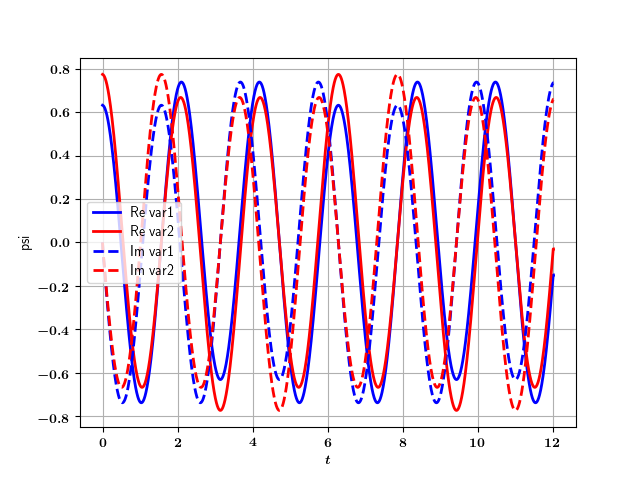

In [4]:
# ---------------------------------------------------
# --- Grid's parameters ---
# ---------------------------------------------------
flag_Hermitian_ = True
flag_trotterization_ = True
flag_theta_ = True

nt_          = 11
t_max_       = 12
diff_nt_plot = 6
nk_    = 10
k_max_ = 100

# time grid:
Nt_    = 1 << nt_
t_     = np.linspace(0, t_max_, Nt_)
dt_    = np.diff(t_)[0]

diff_N_ = 1 << diff_nt_plot
N_plot  = 1 << (nt_ - diff_nt_plot)

t_plot_ = np.zeros(N_plot)
for it in range(N_plot):
    t_plot_[it] = it * diff_N_ * dt_
del it

# k-grid for the LCHS:
Nk_    = 1 << nk_
k_     = np.linspace(-k_max_, k_max_, Nk_)
dk_    = np.diff(k_)[0]

# initial state:
psi_init_ = get_initial_state()

# choose the matrix:
if flag_Hermitian_:
    Hi_ = case_Hermitian()
else:
    Hi_ = case_non_Hermitian()

# reference computation:
psi_ref_ = ref_computation(Hi_, psi_init_)
plot_one_sim(t_, psi_ref_)

In [5]:
# --------------------------------------------
# --- LCHS computation (in python) ---
# --------------------------------------------

# LCHS computation:
if flag_trotterization_:
    print("Performing LCHS computation (with trotterization)...")
else:
    print("Performing LCHS computation (without trotterization)...")
if flag_theta_:
    print("\t[theta-weights]")
else:
    print("\t[k-weights]")

psi_LCHS = np.zeros((N_plot, 2), dtype = complex)
for it in range(N_plot):
    id_t = it * diff_N_  
    if flag_theta_:
        psi_LCHS[it,:] = LCHS_computation_opt2(Hi, psi_init, id_t)
    else:
        psi_LCHS[it,:] = LCHS_computation(Hi, psi_init, id_t, flag_trotterization_, flag_print = False)
del id_t, it
print("Done.")

del Hi, diff_nt_plot, N_plot, psi_init

--- NON-Hermitian Hamiltonian ---

*** Original Hamiltonian (without mult. by i)***
--- 0 ---
 1.000-0.100j  2.000+0.000j
--- 1 ---
 2.000+0.000j  1.000+0.000j

--- refence computation ---
sum psi[RK-max-time]**2: 3.004e-01
Performing LCHS computation (with trotterization)...
	[theta-weights]
Done.


<IPython.core.display.Javascript object>


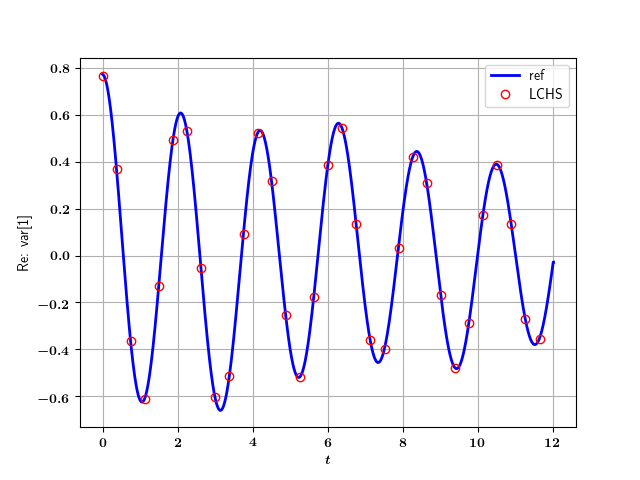

<IPython.core.display.Javascript object>


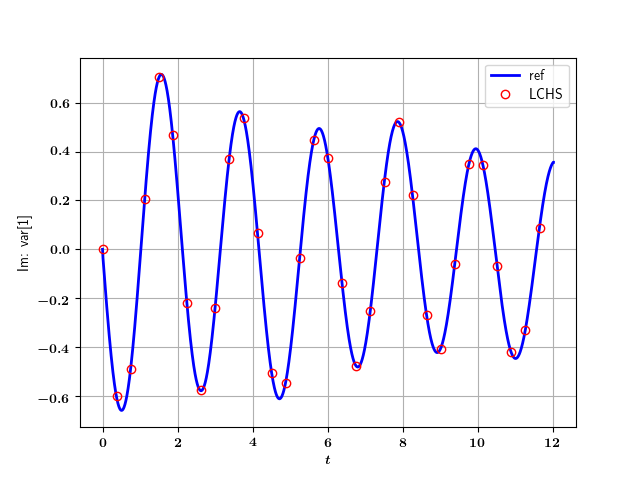

max. abs. err: 1.550e-02


In [6]:
# ----------------------------------------------------------
# --- Plot LCHS results (from python simulations) ---
# ----------------------------------------------------------
compare_plots(psi_ref, psi_LCHS, id_var = 1)

max_abs_err = 0
for it in range(len(t_plot_)):
    err = np.max(np.abs(psi_ref[it * diff_N_] - psi_LCHS[it]))
    if max_abs_err < err:
        max_abs_err = err
print("max. abs. err: {:0.3e}".format(max_abs_err))
del max_abs_err, err , it

In [ ]:
# --- RESULT: 1/err is linear with k_max --------------------------
# nt = 12
# k_max:              10,        20,        40,       400,
# err(opt-k):  4.926e-02, 2.542e-02, 1.391e-02,
# err(opt-th): 4.926e-02, 2.542e-02, 1.391e-02, 3.434e-03,
# -----------------------------------------------------------------

# LCHS scaling (without trotterization) for a Hermitian matrix [[1, 2] [2, 1]]:
k_max_array =  [   10,    10,    10,    20,    20,   100,   200,  1600,  3200]
nk_array    =  [    4,     5,     7,     7,     8,     9,    10,    13,    14]
mlog_err    = -[1.089, 1.197, 1.198, 1.498, 1.498, 2.196, 2.497, 3.400, 3.701]

In [6]:
# ---------------------------------------------------------------------------------------
# --- Parameters for the block encoding ---
# ---------------------------------------------------------------------------------------
mix.reload_module(mix)


def find_nonsparsity(A):
    # Assume that A is a square matrix.
    coef_zero = 1e-12
    N = A.shape[0]
    final_nonsparsity = 0
    for ir in range(N):
        nonsparsity_row = 0
        for ic in range(N):
            if np.abs(A[ir, ic]) > coef_zero:
                nonsparsity_row += 1
        if nonsparsity_row > final_nonsparsity:
            final_nonsparsity = nonsparsity_row
    return final_nonsparsity


def find_norm_of_matrix(A):
    N = A.shape[0]
    rows_sum = np.zeros(N)
    for ir in range(N):
        rows_sum[ir] = np.sqrt(np.sum(np.abs(A[ir,:])**2))
    coef_norm = np.max(rows_sum)
    return coef_norm
    
            
def compute_normalized_matrix(A):
    nonsparsity = find_nonsparsity(A)
    print("Nonsparsity: {:d}".format(nonsparsity))
    if nonsparsity == 0:
        return A, 1.0, 0.0
    final_norm = nonsparsity
    
    coef_norm_A = find_norm_of_matrix(A)
    if coef_norm_A > 1:
        final_norm *= coef_norm_A
        
    A_norm = A / final_norm
    
    return A_norm, final_norm, nonsparsity


def compute_angles_2x2(A_norm, nonsparsity, str_A):
    ay_00, az_00 = mix.calc_angles_from_a_value(A_norm[0,0] * nonsparsity)
    ay_01, az_01 = mix.calc_angles_from_a_value(A_norm[0,1] * nonsparsity)
    ay_10, az_10 = mix.calc_angles_from_a_value(A_norm[1,0] * nonsparsity)
    ay_11, az_11 = mix.calc_angles_from_a_value(A_norm[1,1] * nonsparsity)
  
    print("ay_00_{:s}  {:0.12e}".format(str_A, ay_00))
    if az_00 is not None:
        print("az_00_{:s}  {:0.12e}".format(str_A, az_00))

    print("ay_01_{:s}  {:0.12e}".format(str_A, ay_01))
    if az_01 is not None:
        print("az_01_{:s}  {:0.12e}".format(str_A, az_01))

    print("ay_10_{:s}  {:0.12e}".format(str_A, ay_10))
    if az_10 is not None:
        print("az_10_{:s}  {:0.12e}".format(str_A, az_10))

    print("ay_11_{:s}  {:0.12e}".format(str_A, ay_11))
    if az_11 is not None:
        print("az_11_{:s}  {:0.12e}".format(str_A, az_11))
    return

def compute_angles_initialization(psi_init):
    ay_init = 2*np.arccos(psi_init.real[0])
    print("ay_init  {:0.12e}".format(ay_init))
    return
# --------------------------------------------------------------------------------------------    
    
# --- Find Hermitian and anti-Hermitian parts of the system ---
Ah, Aa = get_herm_aherm_parts(Hi_)

print("\n*** Hermitian part of i*H ***")
mix.print_matrix(Ah)

print("\n*** Anti-Hermitian part of i*H ***")
mix.print_matrix(Aa)

B_kmax = Aa - k_max_ * Ah
Bk     = dk_ * Ah

# --- Normalize the hermitian and anti-Hermitian parts of the matrix ---
B_kmax_norm, ncoef_kmax, nonsparsity_kmax = compute_normalized_matrix(B_kmax)
Bk_norm, ncoef_k, nonsparsity_k = compute_normalized_matrix(Bk)

print("\n*** Normalized (Aa - kmax*Ah) ***")
mix.print_matrix(B_kmax_norm, ff=[25, 3, "e"])

print("\n*** Normalized dk*Ah ***")
mix.print_matrix(Bk_norm, ff=[25, 3, "e"])

# Print initial state:
psi_init = get_initial_state()
print("\n*** Initial state ***")
mix.print_array(psi_init, ff=[25, 3, "e"])




# --- The number of qubits for encoding of variables ---
print("\n\n//--- For data ---")
print("nx \t{:d}".format(1))
print("Nt \t{:d}".format(Nt_))

# --- Compute angles for the herm. and a-herm. matrices ---
print("\n//--- The angles for the BE oracles ---")
if nonsparsity_kmax > 0:
    compute_angles_2x2(B_kmax_norm, nonsparsity_kmax, "kmax")
if nonsparsity_k > 0:
    compute_angles_2x2(Bk_norm, nonsparsity_k, "k")

# --- Compute angles for the initialization circuit ---
print("\n//--- The angles for the initialization ---")
compute_angles_initialization(psi_init_)

# --- Compute angles for the weights ---
alpha_k0 = - 1.0
alpha_k1 = Nk_/(Nk_ - 1)

print("\n//--- For weights ---")
print("nk \t{:d}".format(nk_))
print("alpha_k0 \t{:0.12e}".format(alpha_k0))
print("alpha_k1 \t{:0.12e}".format(alpha_k1))

del alpha_k0, alpha_k1


*** Hermitian part of i*H ***
--- 0 ---
 0.000+0.000j  0.000+0.000j
--- 1 ---
 0.000+0.000j  0.000+0.000j

*** Anti-Hermitian part of i*H ***
--- 0 ---
 1.000+0.000j  2.000+0.000j
--- 1 ---
 2.000+0.000j  1.000+0.000j
Nonsparsity: 2
Nonsparsity: 0

*** Normalized (Aa - kmax*Ah) ***
--- 0 ---
     2.236e-01+0.000e+00j      4.472e-01+0.000e+00j
--- 1 ---
     4.472e-01+0.000e+00j      2.236e-01+0.000e+00j

*** Normalized dk*Ah ***
--- 0 ---
     0.000e+00+0.000e+00j      0.000e+00+0.000e+00j
--- 1 ---
     0.000e+00+0.000e+00j      0.000e+00+0.000e+00j

*** Initial state ***
     6.325e-01+0.000e+00j      7.746e-01+0.000e+00j 


//--- For data ---
nx 	1
Nt 	2048

//--- The angles for the BE oracles ---
ay_00_kmax  2.214297435588e+00
ay_01_kmax  9.272952180016e-01
ay_10_kmax  9.272952180016e-01
ay_11_kmax  2.214297435588e+00

//--- The angles for the initialization ---
ay_init  1.772154247585e+00

//--- For weights ---
nk 	10
alpha_k0 	-1.000000000000e+00
alpha_k1 	1.000977517107e+00



Reading the file ../QuCF/tests/LCHS-Hermitian-simple//N_5_OUTPUT.hdf5...
Name of the simulation is N_5
Simulation has been performed  12-20-2023 20:45:45
Reading the file:  ../QuCF/tests/LCHS-Hermitian-simple/QSP_ham_t05_eps12.hdf5

---------------------------
QSP-time-step-kmax: 	5.000e-01

Reading the file ../QuCF/tests/LCHS-Hermitian-simple//N_10_OUTPUT.hdf5...
Name of the simulation is N_10
Simulation has been performed  12-20-2023 20:45:49
Reading the file:  ../QuCF/tests/LCHS-Hermitian-simple/QSP_ham_t05_eps12.hdf5

---------------------------
QSP-time-step-kmax: 	5.000e-01

Reading the file ../QuCF/tests/LCHS-Hermitian-simple//N_15_OUTPUT.hdf5...
Name of the simulation is N_15
Simulation has been performed  12-20-2023 20:45:52
Reading the file:  ../QuCF/tests/LCHS-Hermitian-simple/QSP_ham_t05_eps12.hdf5

---------------------------
QSP-time-step-kmax: 	5.000e-01

Reading the file ../QuCF/tests/LCHS-Hermitian-simple//N_20_OUTPUT.hdf5...
Name of the simulation is N_20
Simulation 

<IPython.core.display.Javascript object>


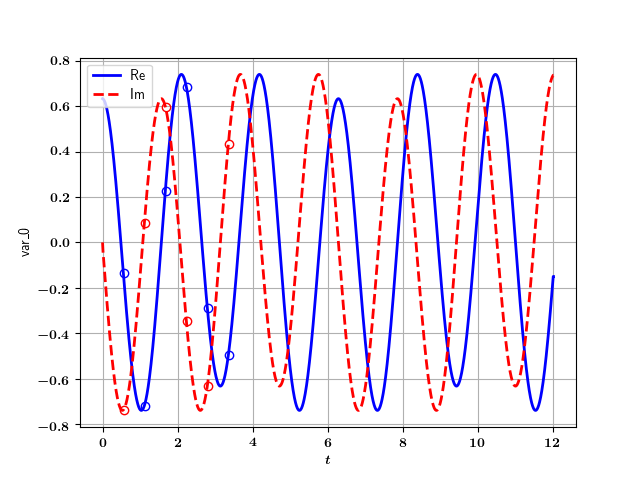

In [27]:
# --------------------------------------------------------
# --- Read results from quantum simulations ---
# --------------------------------------------------------
import h5py
mix.reload_module(mse)

# -------------------------------------------------
def read_time_step(fname):
    print("Reading the file: ", fname)
    with h5py.File(fname, "r") as f:
        time_step = f["basic"]["par"][()]
    return time_step


def plot_QC_vs_REF(t_ref, psi_ref, qt_points, psi_qc_points, id_var):
    fig = plt.figure()
    ax = fig.add_subplot(111)   
    ax.plot(t_ref, psi_ref.real[:,id_var], "-b", linewidth = 2, label="Re")
    ax.plot(t_ref, psi_ref.imag[:,id_var], "--r", linewidth = 2, label="Im")
    ax.plot(
        qt_points, psi_qc_points.real[:,id_var], 
        "o", markerfacecolor='None', markeredgecolor='b', linestyle='None'
    )
    ax.plot(
        qt_points, psi_qc_points.imag[:,id_var], 
        "o", markerfacecolor='None', markeredgecolor='r', linestyle='None'
    ) 
    plt.xlabel('$t$')
    plt.ylabel("var_{:d}".format(id_var))
    ax.legend()
    plt.grid(True)
    plt.show()
    return

def read_data(Nt_point):
    print()
    if flag_Hermitian_:
        path_work = "../QuCF/tests/LCHS-Hermitian-simple/"
    else:
        path_work = "../QuCF/tests/LCHS-non-Hermitian-simple/"
    pro_name_work = "N_{:d}".format(Nt_point)
    qsp_kmax_name = "QSP_ham_t05_eps12.hdf5"

    # --- Read the _OUTPUT.hdf5 file ---
    om = mse.MeasOracle__()
    om.path_  = path_work
    om.pname_ = pro_name_work
    om.open()
    om.set_zero_ancillae_work_states(0)
    
    # --- the final state ---
    qc_state_t = om.get_var_x({}, "rx")
#     qc_state_t *= dk_ / np.pi
    
#     Hadamart_norm_factor = 2**(nk_/2) # the rescaling factor appears to the initialization circuit;
#     qsvt_nnorm_factor = 0.98
#     coef_norm = Hadamart_norm_factor / qsvt_nnorm_factor
    
#     qc_state_t *= dk_ / np.pi
#     qc_state_t *= coef_norm

    # --- Finding the simulated time interval ---
    Nt = int(om.constants_["Nt"])

    t_step_qsp_kmax = read_time_step(path_work + qsp_kmax_name)
    t_step_kmax = t_step_qsp_kmax / ncoef_kmax
    print("\n---------------------------")
    print("QSP-time-step-kmax: \t{:0.3e}".format(t_step_qsp_kmax))

    if not flag_Hermitian_:
        t_step_qsp_k  = read_time_step(path_work + qsp_k_name)
        t_step_k      = t_step_qsp_k / ncoef_k
        print("QSP-time-step-k: \t{:0.3e}".format(t_step_qsp_k))
        # compare t_step_kmax and t_step_k: should be t_step_kmax = t_step_k / 2;

    if flag_Hermitian_:
        qt_final = t_step_kmax * Nt
    else:
        qt_final = t_step_k * Nt    
    return qt_final, qc_state_t


# ------------------------------------------------


Nt_points = [5, 10, 15, 20, 25, 30]
psi_qc    = np.zeros((len(Nt_points), 2), dtype=complex)
qt_points = np.zeros(len(Nt_points))
for ii in range(len(Nt_points)):
    qt_one, psi_one = read_data(Nt_points[ii])
    qt_points[ii] = qt_one
    psi_qc[ii, :] = psi_one  
                     
plot_QC_vs_REF(t_, psi_ref_, qt_points, psi_qc, id_var = 0)

In [14]:
psi_qc

array([[0.544+0.003j, 0.665-0.j   ],
       [0.544+0.003j, 0.665-0.j   ],
       [0.544+0.003j, 0.665-0.j   ]])